54.1% sur Classique sans aug 

50.7% sur Progressif sans aug

## Dictionaires de données

In [1]:
%%time

num_aug=7


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os


imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   
    images_base_vide+=[im]
    label_nom_vide+=[file.split('\\')[1].split('_')[0]]   
images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            deg_rot=(k%2)*(((k+1)//2))*5+(1-k%2)*(((k+1)//2)*(-5))
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), deg_rot, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique,data_aug=num_aug)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('\\')[1].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('\\')[1].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif,data_aug=num_aug)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

Wall time: 50.6 s


In [2]:
Train_Classique['image'].shape , Test_Classique['image'].shape

((8456, 64, 64), (303, 64, 64))

In [3]:
Train_Progressif['image'].shape , Test_Progressif['image'].shape

((8477, 64, 64), (300, 64, 64))

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import random

In [5]:
tf.__version__

'1.12.0'

In [6]:
Train_dic=Train_Classique
Test_dic=Test_Classique

In [7]:
num_training=Train_dic['image'].shape[0]


img_size_flat = Train_dic['data'].shape[1]


img_shape = Train_dic['image'].shape[1:]


num_classes = 4

In [8]:
def plot_9_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

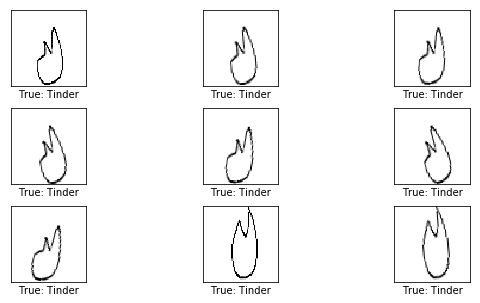

In [9]:
images = Train_dic['image'][0:9]
cls_true = [num_to_label[i] for i in Train_dic['label_num'][0:9]]

plot_9_images(images=images, cls_true=cls_true)

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [11]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [12]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [13]:
poids = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [14]:
biases = tf.Variable(tf.zeros([num_classes]))

In [15]:
logits = tf.matmul(x, poids) + biases

In [16]:
y_pred = tf.nn.softmax(logits)

In [17]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [19]:
cost = tf.reduce_mean(cross_entropy)

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
session = tf.Session()

In [24]:
session.run(tf.global_variables_initializer())

In [25]:
batch_size = 100

In [26]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

In [28]:
feed_dict_test = {x: Test_dic['data'], y_true: Test_dic['label_OneHot'], y_true_cls: Test_dic['label_num']}

In [29]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [30]:
def matrice_de_confusion():

    cls_true = Test_dic['label_num']
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)

    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Prédite')
    plt.ylabel('Vraie')
    
    plt.show()

In [31]:
def examples_erreurs():
    
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = Test_dic['data'][incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_true = Test_dic['label_num'][incorrect]
    
    plot_9_images(images=images[0:9],
                cls_true=[num_to_label[i] for i in cls_true[0:9]],
                cls_pred=[num_to_label[i] for i in cls_pred[0:9]])

In [32]:
def visualisation_poids():
    
    w = session.run(poids)
 
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(2, 2)


    for i, ax in enumerate(axes.flat):

        image = w[:, i].reshape(img_shape)
        ax.set_xlabel("Poids: {0}".format(num_to_label[i]))
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [33]:
print_accuracy()

Accuracy on test-set: 20.8%


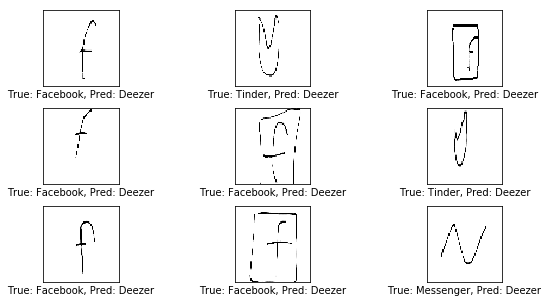

In [34]:
examples_erreurs()

In [35]:
optimize(num_iterations=1)

In [36]:
print_accuracy()

Accuracy on test-set: 21.1%


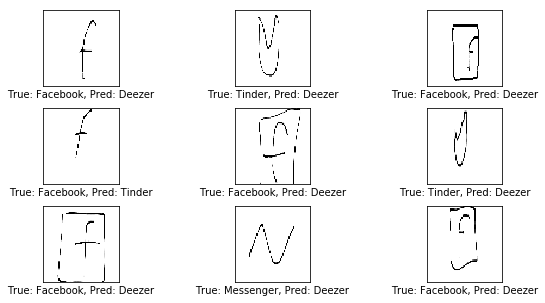

In [37]:
examples_erreurs()

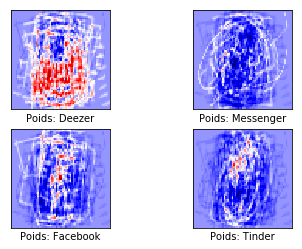

In [38]:
visualisation_poids()

In [39]:
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 37.0%


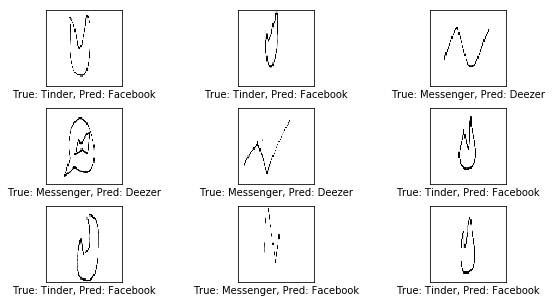

In [41]:
examples_erreurs()

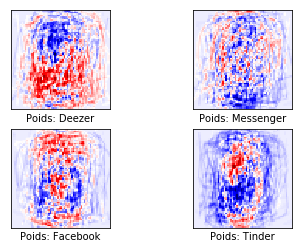

In [42]:
visualisation_poids()

In [43]:
optimize(num_iterations=990)

In [44]:
print_accuracy()

Accuracy on test-set: 44.2%


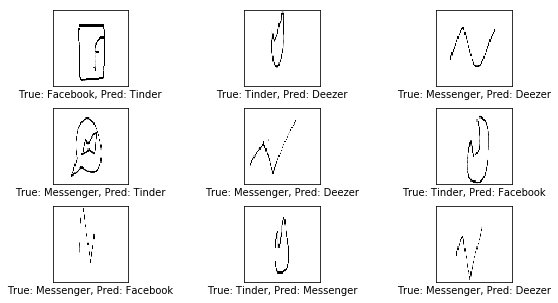

In [45]:
examples_erreurs()

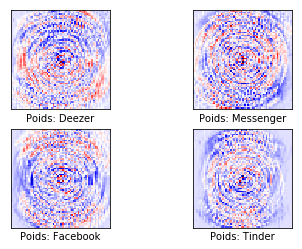

In [46]:
visualisation_poids()

[[38  9  8  8]
 [22 29 15 11]
 [19 26 27  9]
 [11 16 15 40]]


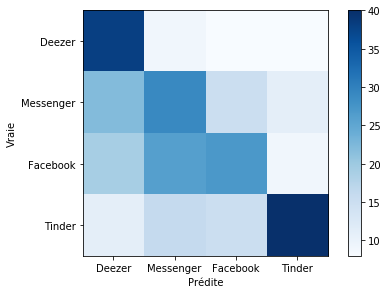

In [47]:
matrice_de_confusion()

In [48]:
optimize(num_iterations=1000)

print_accuracy()

Accuracy on test-set: 47.9%


In [49]:
%%time
optimize(num_iterations=10000)

print_accuracy()

Accuracy on test-set: 41.6%
Wall time: 1min 25s


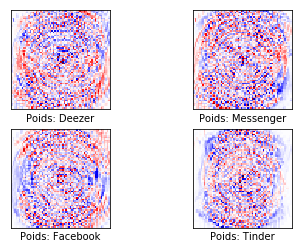

In [50]:
visualisation_poids()